# OCOM510M Data Science: Assessment 2

Student ID: 201912075

WORD COUNT: 2677

## 1. Aims, objectives and plan

### Aims and objectives

The main aim of the current project is to provide two prediction (classification) techniques in help of an insurance company such that the company minimises their loss from either losing clients because of misclassifying claims as being a fraud or from incorrectly marking a claim as genuine while it being a fraud. In order to do that the insurance company's historic insurance fraud dataset is used. The data is analysed and preprocessed before the two chosen classifiers are applied. The two techniques are optimised and their performances are compared to each other. Additionally, it is calculated which one of the classification models would lead to more financial loss for the company. Finally, based on all the comparisons, one of the classification models is recommended to the insurance company.

### Plan

<img src="Gantt Chart.png" alt="drawing" style="width:80%"/>

## 2. Understanding the case study

###  Case study analysis

Based on the provided context, some key points should be addressed.

1. The project is going to be based on the historic data of the insurance company which probably represents medium to large amount of records. Having big real data, this might mean dealing with numerous data problems. For example, the raw data may suffer from missing values, outliers, attributes correlations and others. Hence, the data should be thoroughly explored and suitable data preprocessing techniques might need to be implemented in order to prepare the dataset for further analyses.

1. The data should also be checked for class imbalance as it might lower the performaces of the classification techniques. The current project deals with a binary classification problem as there are two classes - "fraud" and "not fraud". If either of them is represented way more than the other, this might make a classification approach to prioritise the majority class and ignore the minority class. Hence, if there is a problem with a class imbalance, it should be resolved. For example, oversampling of the minority class and/or undersampling of the majority class may be done.

1. One of the main goals of the project is to present two classification techniques and by comparing them to propose one of them as the better option. In order to do that, suitable performance metrics should be applied. For example, the recall metrics should probably be used because it is a lot more important to minimise the cases where the model predicts a genuine claim while it is a fraud in reality as this would probably lead to more financial loss for the insurance company. Additionally, it should be made sure that the classifiers are compared in an unbiased way. So, a method such as the nested cross validation should be used, for example.

1. Finally, it should be shown to the insurance company which of the two classification techniques would lead to less financial loss for them. In order to do that an example pricing model should be constructed. It should be taken into consideration that misclassifying a fraudulent claim as genuine would most probably lead to a bigger loss compared to loosing a client for misclassifying a genuine claim. Hence, it is not guaranteed that the algorithm which has shown better performance metrics is the one which would lead to less financial loss for the company, as well.

## 3. Pre-processing applied

### Loading the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

df_claim = pd.read_csv('Train_Claim.csv')
df_demographics = pd.read_csv('Train_Demographics.csv')
df_policy = pd.read_csv('Train_Policy.csv')
df_vehicle = pd.read_csv('Train_Vehicle.csv')
df_target = pd.read_csv('Traindata_with_Target.csv')

In [2]:
print(f"Number of records in df_claim: {df_claim.shape}")
print(f"Number of records in df_demographics: {df_demographics.shape}")
print(f"Number of records in df_policy: {df_policy.shape}")
print(f"Number of records in df_vehicle: {df_vehicle.shape}")
print(f"Number of records in df_target: {df_target.shape}")

Number of records in df_claim: (28836, 19)
Number of records in df_demographics: (28836, 10)
Number of records in df_policy: (28836, 10)
Number of records in df_vehicle: (115344, 3)
Number of records in df_target: (28836, 2)


### Pivoting

From the observations above, the 'df_vehicle' DataFrame has 4 times more rows compared to the other DataFrames. The following code snippet investigates what is different in the 'df_vehicle' DataFrame

In [3]:
df_vehicle.sort_values(by=['CustomerID']).head(20)

,CustomerID,VehicleAttribute,VehicleAttributeDetails
40353,Cust10000,VehicleModel,A5
97996,Cust10000,VehicleMake,Audi
5865,Cust10000,VehicleID,Vehicle26917
51765,Cust10000,VehicleYOM,2008
589,Cust10001,VehicleYOM,2006
40108,Cust10001,VehicleModel,A5
1112,Cust10001,VehicleID,Vehicle15893
66356,Cust10001,VehicleMake,Audi
77068,Cust10002,VehicleModel,Jetta
84853,Cust10002,VehicleID,Vehicle5152


From the above code cell, there are 4 records for every 'CustomerID'. Hence, pivoting the data would be useful. It would be more suitable the 'VehicleID'/'VehicleMake'/'VehicleModel'/'VehicleYOM' readings to be used as attributes since they are not expected to change and querying the data would be more effective this way.

In [4]:
df_vehicle = df_vehicle.pivot(index='CustomerID', columns='VehicleAttribute', values='VehicleAttributeDetails').reset_index()
df_vehicle

VehicleAttribute,CustomerID,VehicleID,VehicleMake,VehicleModel,VehicleYOM
0,Cust10000,Vehicle26917,Audi,A5,2008
1,Cust10001,Vehicle15893,Audi,A5,2006
2,Cust10002,Vehicle5152,Volkswagen,Jetta,1999
3,Cust10003,Vehicle37363,Volkswagen,Jetta,2003
4,Cust10004,Vehicle28633,Toyota,CRV,2010
...,...,...,...,...,...
28831,Cust9993,Vehicle13568,Suburu,Impreza,2007
28832,Cust9994,Vehicle19810,Jeep,Wrangler,2003
28833,Cust9996,Vehicle3339,Suburu,Legacy,2004
28834,Cust9997,Vehicle10240,Suburu,Forrestor,2004


In [5]:
# df_insurance is the main DataFrame, combining the information from all four sub-DataFrames
df_insurance = pd.merge(df_claim, df_demographics, on='CustomerID', how='outer')
df_insurance = pd.merge(df_insurance, df_policy, on='CustomerID', how='outer')
df_insurance = pd.merge(df_insurance, df_vehicle, on='CustomerID', how='outer')
df_insurance = pd.merge(df_insurance, df_target, on='CustomerID', how='outer')

df_insurance.sort_values(by=['CustomerID'], inplace=True)
df_insurance

,CustomerID,DateOfIncident,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,IncidentTime,...,Policy_CombinedSingleLimit,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,InsuredRelationship,VehicleID,VehicleMake,VehicleModel,VehicleYOM,ReportedFraud
0,Cust10000,2015-02-03,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City1,Location 1311,17,...,100/300,1000,1632.73,0,not-in-family,Vehicle26917,Audi,A5,2008,N
1,Cust10001,2015-02-02,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City5,Location 1311,10,...,100/300,1000,1255.19,0,not-in-family,Vehicle15893,Audi,A5,2006,N
2,Cust10002,2015-01-15,Single Vehicle Collision,Side Collision,Minor Damage,Other,State8,City6,Location 2081,22,...,500/1000,617,1373.38,0,wife,Vehicle5152,Volkswagen,Jetta,1999,N
3,Cust10003,2015-01-19,Single Vehicle Collision,Side Collision,Minor Damage,Other,State9,City6,Location 2081,22,...,500/1000,722,1337.60,0,own-child,Vehicle37363,Volkswagen,Jetta,2003,N
4,Cust10004,2015-01-09,Single Vehicle Collision,Rear Collision,Minor Damage,Fire,State8,City6,Location 1695,10,...,100/300,500,1353.73,4279863,unmarried,Vehicle28633,Toyota,CRV,2010,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28831,Cust9993,2015-01-24,Vehicle Theft,?,Trivial Damage,Police,State9,City4,Location 1890,3,...,500/1000,655,1276.01,0,unmarried,Vehicle13568,Suburu,Impreza,2007,N
28832,Cust9994,2015-02-09,Single Vehicle Collision,Front Collision,Minor Damage,Fire,State8,City3,Location 2097,17,...,100/300,1089,1273.38,0,unmarried,Vehicle19810,Jeep,Wrangler,2003,N
28833,Cust9996,2015-01-28,Single Vehicle Collision,Rear Collision,Minor Damage,Fire,State9,City7,Location 1452,1,...,250/500,787,1380.92,3448735,own-child,Vehicle3339,Suburu,Legacy,2004,N
28834,Cust9997,2015-01-28,Single Vehicle Collision,Rear Collision,Minor Damage,Ambulance,State9,City3,Location 1876,1,...,250/500,780,1389.29,3364301,not-in-family,Vehicle10240,Suburu,Forrestor,2004,N


Below, the data is looked at in more details and is checked for having any duplicates

In [6]:
df_insurance.describe()

,IncidentTime,NumberOfVehicles,BodilyInjuries,AmountOfInjuryClaim,AmountOfPropertyClaim,AmountOfVehicleDamage,InsuredAge,InsuredZipCode,CapitalGains,CapitalLoss,InsurancePolicyNumber,CustomerLoyaltyPeriod,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit
count,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,2.883600e+04
mean,11.746047,1.823207,0.985782,7337.118428,7283.870197,37687.129387,38.815370,502436.579068,23066.569566,-24940.612429,129312.517097,203.067867,1114.282529,1255.528382,9.836680e+05
std,6.170069,0.980099,0.784764,4427.638593,4375.842738,17977.048232,7.996377,72250.868871,27637.813724,27913.209608,11114.060267,99.932951,546.632816,223.013899,1.969282e+06
min,-5.000000,1.000000,0.000000,0.000000,0.000000,109.000000,19.000000,430104.000000,0.000000,-111100.000000,110122.000000,1.000000,500.000000,-1.000000,-1.000000e+06
25%,6.000000,1.000000,0.000000,4743.750000,4862.000000,32193.250000,33.000000,448603.000000,0.000000,-50000.000000,119698.750000,126.000000,622.000000,1122.007500,0.000000e+00
50%,12.000000,1.000000,1.000000,7147.000000,7051.000000,42457.500000,38.000000,466691.000000,0.000000,0.000000,129278.500000,199.000000,1000.000000,1265.205000,0.000000e+00
75%,17.000000,3.000000,2.000000,10571.250000,10327.000000,49535.750000,44.000000,603848.000000,49000.000000,0.000000,138933.250000,267.000000,1627.000000,1396.605000,4.859610e+05
max,23.000000,4.000000,2.000000,21450.000000,23670.000000,79560.000000,64.000000,620962.000000,100500.000000,0.000000,148619.000000,479.000000,2000.000000,2047.590000,1.000000e+07


In [7]:
df_insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CustomerID                  28836 non-null  object 
 1   DateOfIncident              28836 non-null  object 
 2   TypeOfIncident              28836 non-null  object 
 3   TypeOfCollission            28836 non-null  object 
 4   SeverityOfIncident          28836 non-null  object 
 5   AuthoritiesContacted        26144 non-null  object 
 6   IncidentState               28836 non-null  object 
 7   IncidentCity                28836 non-null  object 
 8   IncidentAddress             28836 non-null  object 
 9   IncidentTime                28836 non-null  int64  
 10  NumberOfVehicles            28836 non-null  int64  
 11  PropertyDamage              28836 non-null  object 
 12  BodilyInjuries              28836 non-null  int64  
 13  Witnesses                   288

In [8]:
df_insurance.duplicated().sum()

0

### Dealing with missingness

In [9]:
missing_data = df_insurance.isnull().any()
print(missing_data)

CustomerID                    False
DateOfIncident                False
TypeOfIncident                False
TypeOfCollission              False
SeverityOfIncident            False
AuthoritiesContacted           True
IncidentState                 False
IncidentCity                  False
IncidentAddress               False
IncidentTime                  False
NumberOfVehicles              False
PropertyDamage                False
BodilyInjuries                False
Witnesses                     False
PoliceReport                  False
AmountOfTotalClaim            False
AmountOfInjuryClaim           False
AmountOfPropertyClaim         False
AmountOfVehicleDamage         False
InsuredAge                    False
InsuredZipCode                False
InsuredGender                  True
InsuredEducationLevel         False
InsuredOccupation             False
InsuredHobbies                False
CapitalGains                  False
CapitalLoss                   False
Country                     

In [10]:
print(f"Total amount of records: {df_insurance.shape[0]}")

Total amount of records: 28836


In [11]:
print(f"Number of NA values in 'AuthoritiesContacted' attribute: {df_insurance['AuthoritiesContacted'].isnull().sum()}")
print(f"Number of NA values in 'InsuredGender' attribute: {df_insurance['InsuredGender'].isnull().sum()}")
print(f"Number of NA values in 'Country' attribute: {df_insurance['Country'].isnull().sum()}")

Number of NA values in 'AuthoritiesContacted' attribute: 2692
Number of NA values in 'InsuredGender' attribute: 30
Number of NA values in 'Country' attribute: 2


According to the 'AttributeInformation.pdf' document, some attributes have more specific missing values. The missing value for 'PolicyAnnualPremium' is represented as '-1'. The missing value for 'TypeOfCollission' is represented as '?'. The missing value for 'IncidentTime' is represented as '-5'. The missing value for 'PropertyDamage' is represented as '?'. The missing value for 'Witnesses' is represented as 'MISSINGVALUE'. The missing value for 'PoliceReport' is represented as '?'. The missing value for 'AmountOfTotalClaim' is represented as 'MISSEDDATA'. The missing value for 'VehicleAttributeDetails' is represented as '???'.

In [12]:
print(f"Number of missing values in 'PolicyAnnualPremium' attribute: {df_insurance[df_insurance['PolicyAnnualPremium']==-1].shape[0]}")
print(f"Number of missing values in 'TypeOfCollission' attribute: {df_insurance[df_insurance['TypeOfCollission']=='?'].shape[0]}")
print(f"Number of missing values in 'IncidentTime' attribute: {df_insurance[df_insurance['IncidentTime']==-5].shape[0]}")
print(f"Number of missing values in 'PropertyDamage' attribute: {df_insurance[df_insurance['PropertyDamage']=='?'].shape[0]}")
print(f"Number of missing values in 'Witnesses' attribute: {df_insurance[df_insurance['Witnesses']=='MISSINGVALUE'].shape[0]}")
print(f"Number of missing values in 'PoliceReport' attribute: {df_insurance[df_insurance['PoliceReport']=='?'].shape[0]}")
print(f"Number of missing values in 'AmountOfTotalClaim' attribute: {df_insurance[df_insurance['AmountOfTotalClaim']=='MISSEDDATA'].shape[0]}")
print(f"Number of missing values in 'VehicleID' attribute: {df_insurance[df_insurance['VehicleID']=='???'].shape[0]}")
print(f"Number of missing values in 'VehicleMake' attribute: {df_insurance[df_insurance['VehicleMake']=='???'].shape[0]}")
print(f"Number of missing values in 'VehicleModel' attribute: {df_insurance[df_insurance['VehicleModel']=='???'].shape[0]}")
print(f"Number of missing values in 'VehicleYOM' attribute: {df_insurance[df_insurance['VehicleYOM']=='???'].shape[0]}")

Number of missing values in 'PolicyAnnualPremium' attribute: 141
Number of missing values in 'TypeOfCollission' attribute: 5162
Number of missing values in 'IncidentTime' attribute: 31
Number of missing values in 'PropertyDamage' attribute: 10459
Number of missing values in 'Witnesses' attribute: 46
Number of missing values in 'PoliceReport' attribute: 9805
Number of missing values in 'AmountOfTotalClaim' attribute: 50
Number of missing values in 'VehicleID' attribute: 0
Number of missing values in 'VehicleMake' attribute: 50
Number of missing values in 'VehicleModel' attribute: 0
Number of missing values in 'VehicleYOM' attribute: 0


From the above observations, the 'InsuredGender', 'Country', 'PolicyAnnualPremium', 'IncidentTime', 'Witnesses', 'AmountOfTotalClaim' and 'VehicleMake' attributes have a relatively small number of missing values. Hence, all these records are dropped.

In [13]:
try:
    df_insurance.dropna(subset=['InsuredGender', 'Country'], inplace=True)
except KeyError as e:
    print(e)
    
df_insurance.shape

(28804, 42)

In [14]:
records_to_remove = df_insurance[(df_insurance['PolicyAnnualPremium'] == -1) |
                            (df_insurance['IncidentTime'] == -5) |
                            (df_insurance['Witnesses'] == 'MISSINGVALUE') |
                            (df_insurance['AmountOfTotalClaim'] == 'MISSEDDATA') |
                            (df_insurance['VehicleMake'] == '???')].index

try:
    df_insurance.drop(records_to_remove, inplace = True)
except KeyError as e:
    print(e)

print(df_insurance.shape)

(28567, 42)


In [15]:
print(f"Number of missing values in 'PolicyAnnualPremium' attribute: {df_insurance[df_insurance['PolicyAnnualPremium']==-1].shape[0]}")
print(f"Number of missing values in 'TypeOfCollission' attribute: {df_insurance[df_insurance['TypeOfCollission']=='?'].shape[0]}")
print(f"Number of missing values in 'IncidentTime' attribute: {df_insurance[df_insurance['IncidentTime']==-5].shape[0]}")
print(f"Number of missing values in 'PropertyDamage' attribute: {df_insurance[df_insurance['PropertyDamage']=='?'].shape[0]}")
print(f"Number of missing values in 'Witnesses' attribute: {df_insurance[df_insurance['Witnesses']=='MISSINGVALUE'].shape[0]}")
print(f"Number of missing values in 'PoliceReport' attribute: {df_insurance[df_insurance['PoliceReport']=='?'].shape[0]}")
print(f"Number of missing values in 'AmountOfTotalClaim' attribute: {df_insurance[df_insurance['AmountOfTotalClaim']=='MISSEDDATA'].shape[0]}")
print(f"Number of missing values in 'VehicleMake' attribute: {df_insurance[df_insurance['VehicleMake']=='???'].shape[0]}")

Number of missing values in 'PolicyAnnualPremium' attribute: 0
Number of missing values in 'TypeOfCollission' attribute: 5117
Number of missing values in 'IncidentTime' attribute: 0
Number of missing values in 'PropertyDamage' attribute: 10363
Number of missing values in 'Witnesses' attribute: 0
Number of missing values in 'PoliceReport' attribute: 9728
Number of missing values in 'AmountOfTotalClaim' attribute: 0
Number of missing values in 'VehicleMake' attribute: 0


In [16]:
# Converting the type of the 'AmountOfTotalClaim' and the 'Witnesses' attributes from object to float
# and the 'DateOfIncident' and 'DateOfPolicyCoverage' from object to datetime
df_insurance['AmountOfTotalClaim'] = df_insurance['AmountOfTotalClaim'].astype(float)
df_insurance['Witnesses'] = df_insurance['Witnesses'].astype(float)
df_insurance['DateOfIncident'] = pd.to_datetime(df_insurance['DateOfIncident'])

In [17]:
df_date = pd.DataFrame()
df_date['CustomerID'] = df_insurance['CustomerID']
df_date['DayOfIncident'] = pd.DatetimeIndex(df_insurance['DateOfIncident']).day
df_date['MonthOfIncident'] = pd.DatetimeIndex(df_insurance['DateOfIncident']).month
df_date['YearOfIncident'] = pd.DatetimeIndex(df_insurance['DateOfIncident']).year

try:
    df_insurance.drop('DateOfIncident', axis=1, inplace=True)
except KeyError as e:
    print(e)

df_insurance = pd.merge(df_date, df_insurance, on='CustomerID', how='outer')

In [18]:
df_date = pd.DataFrame()
df_date['CustomerID'] = df_insurance['CustomerID']
df_date['DayOfPolicyCoverage'] = pd.DatetimeIndex(df_insurance['DateOfPolicyCoverage']).day
df_date['MonthOfPolicyCoverage'] = pd.DatetimeIndex(df_insurance['DateOfPolicyCoverage']).month
df_date['YearOfPolicyCoverage'] = pd.DatetimeIndex(df_insurance['DateOfPolicyCoverage']).year

try:
    df_insurance.drop('DateOfPolicyCoverage', axis=1, inplace=True)
except KeyError as e:
    print(e)

df_insurance = pd.merge(df_date, df_insurance, on='CustomerID', how='outer')

The 'IncidentAddress' and the 'VehicleID' attributes are dropped from the data, too. This decision is made because when being one-hot-encoded these features would create too big number of new attributes which would make the processes' times too big for the purposes of this project. It should be mentioned though that with removing these attributes, important information might be lost with them, as well.

In [19]:
try:
    df_insurance = df_insurance.drop(['IncidentAddress', 'VehicleID'], axis =1)
except KeyError as e:
    print(e)

From the check a few cells above, the 'AuthoritiesContacted', 'TypeOfCollission', 'PropertyDamage' and 'PoliceReport' attributes have a lot more missing values. Hence, data imputation is done for these attributes after splitting the data into Testing and Training sets in order to avoid data leakage.

### Dealing with class imbalance

In [20]:
df_insurance['ReportedFraud'].value_counts()

ReportedFraud
N    20857
Y     7710
Name: count, dtype: int64

As can be seen above, the ration between the 'fraud':'not fraud' classes is around 1:3. In order to deal with this classes imbalance, random under sampling and random over sampling are used. It is decided that both techniques are used because oversampling might lead to overfitting while undersampling might lead to the loss of important records. So, when both are used the disadvantages are as minimised as possible.

In [21]:
# The following code is inspired by (Rafael Alencar, 2017)
count_class_0, count_class_1 = df_insurance['ReportedFraud'].value_counts()

df_class_0 = df_insurance[df_insurance['ReportedFraud'] == 'N']
df_class_1 = df_insurance[df_insurance['ReportedFraud'] == 'Y']

df_class_0_under = df_class_0.sample(2 * count_class_1)
df_class_1_over = df_class_1.sample(2 * count_class_1, replace = True)
df_insurance = pd.concat([df_class_0_under, df_class_1_over], axis=0)

df_insurance['ReportedFraud'].value_counts()

ReportedFraud
N    15420
Y    15420
Name: count, dtype: int64

As can be seen from above, now there are an equal number of samples from both classes

### Check for target classes distribution and apply stratifiction

In [22]:
# Check the percentage of not a fraud/fraud target values
(df_insurance['ReportedFraud'].value_counts()) / df_insurance.shape[0] * 100

ReportedFraud
N    50.0
Y    50.0
Name: count, dtype: float64

From the check above, there is a 50:50 split between the two classes which is exactly what was intended. Later, when splitting the data into Training and Testing sets, stratification is used in order persevere this distribution among both sets.

In [23]:
try:
    X = df_insurance.drop(['CustomerID', 'ReportedFraud'], axis =1)
except KeyError as e:
    print(e)
    
y = df_insurance['ReportedFraud']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [25]:
# Check to make sure the same target class distribution is preserved
print(f"The ration not a fraud/fraud in the Training set:\n {(y_train.value_counts()) / y_train.shape[0] * 100}\n")
print(f"The ration not a fraud/fraud in the Testing set:\n {(y_test.value_counts()) / y_test.shape[0] * 100}")

The ration not a fraud/fraud in the Training set:
 ReportedFraud
N    50.0
Y    50.0
Name: count, dtype: float64

The ration not a fraud/fraud in the Testing set:
 ReportedFraud
Y    50.0
N    50.0
Name: count, dtype: float64


From the observations above, the ratio of genuine/fraudulent claims is preserved correctly as desired

In [26]:
try:
    X_train = X_train.reset_index().drop('index', axis =1)
    X_test = X_test.reset_index().drop('index', axis =1)
    y_train = y_train.reset_index().drop('index', axis =1)
    y_test = y_test.reset_index().drop('index', axis =1)
except KeyError as e:
    print(e)

#### Data imputation for 'AuthoritiesContacted', 'TypeOfCollission', 'PropertyDamage' and 'PoliceReport'

In [27]:
print(f"Number of NA values in 'AuthoritiesContacted' attribute: {X_train['AuthoritiesContacted'].isnull().sum()}")
X_train['AuthoritiesContacted'].value_counts()

Number of NA values in 'AuthoritiesContacted' attribute: 1624


AuthoritiesContacted
Police       6050
Fire         4935
Ambulance    4500
Other        4479
Name: count, dtype: int64

In [28]:
print(X_train['TypeOfCollission'].value_counts())
print(X_train['PropertyDamage'].value_counts())
print(X_train['PoliceReport'].value_counts())

TypeOfCollission
Rear Collision     6906
Side Collision     5963
Front Collision    5452
?                  3267
Name: count, dtype: int64
PropertyDamage
?      8105
NO     6880
YES    6603
Name: count, dtype: int64
PoliceReport
NO     7487
?      7357
YES    6744
Name: count, dtype: int64


For all the 'AuthoritiesContacted', 'TypeOfCollission', 'PropertyDamage' and 'PoliceReport' attributes, their missing values are replace with the most frequent value among the rest of their records. The last three attributes have the same missing value - '?', so one imputer for all of them is enough.

In [29]:
imp_nan = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')

X_train[['AuthoritiesContacted']] = imp_nan.fit_transform(X_train[['AuthoritiesContacted']])
X_test[['AuthoritiesContacted']] = imp_nan.transform(X_test[['AuthoritiesContacted']])

imp_question_mark = SimpleImputer(missing_values='?', strategy='most_frequent')
X_train[['TypeOfCollission', 'PropertyDamage', 'PoliceReport']]  = imp_question_mark.fit_transform(X_train[['TypeOfCollission', 'PropertyDamage', 'PoliceReport']])
X_test[['TypeOfCollission', 'PropertyDamage', 'PoliceReport']]  = imp_question_mark.transform(X_test[['TypeOfCollission', 'PropertyDamage', 'PoliceReport']])


In [30]:
print(f"Number of NA values in 'AuthoritiesContacted' attribute: {X_train['AuthoritiesContacted'].isnull().sum()}")
print(f"Number of NA values in 'AuthoritiesContacted' attribute: {X_test['AuthoritiesContacted'].isnull().sum()}")


Number of NA values in 'AuthoritiesContacted' attribute: 0
Number of NA values in 'AuthoritiesContacted' attribute: 0


In [31]:
print(X_train['TypeOfCollission'].value_counts())
print(X_train['PropertyDamage'].value_counts())
print(X_train['PoliceReport'].value_counts())

TypeOfCollission
Rear Collision     10173
Side Collision      5963
Front Collision     5452
Name: count, dtype: int64
PropertyDamage
NO     14985
YES     6603
Name: count, dtype: int64
PoliceReport
NO     14844
YES     6744
Name: count, dtype: int64


### Dealing with outliers

In [32]:
num_columns = X_train.select_dtypes(include=np.number).columns.tolist() # all numerical columns

for i in range(len(num_columns)):
    
    col = num_columns[i]
    mean = np.mean(df_insurance[col])
    std = np.std(df_insurance[col])
    threshold = 3
    outlier = []
    
    for val in df_insurance[col]:
        try:
            z = (val-mean)/std
            if z > threshold:
                outlier.append(val)
        except ZeroDivisionError as e:
            print(e)

    if outlier:
        print('There is/are outlier(s) in {} column. The values are: {}\n'.format(col, outlier))

C:\Users\petro\AppData\Local\Temp\ipykernel_25388\538320627.py:13: RuntimeWarning: invalid value encountered in scalar divide
  z = (val-mean)/std


There is/are outlier(s) in AmountOfInjuryClaim column. The values are: [20749, 20609, 20960, 21041, 20977, 20860, 20579, 21087, 21407, 20602, 20681, 20846, 20700, 20846, 20699, 20699, 20846]

There is/are outlier(s) in AmountOfPropertyClaim column. The values are: [21188, 21703, 21680, 21105, 21530, 21094, 21223, 20744, 22393, 21316, 21799, 21161, 20701, 21562, 21458, 21743, 21369, 21725, 20554, 21677, 21686, 21280, 21677, 21810, 21732, 21281, 21735, 21796, 20797, 20858, 21735, 21191, 20858, 21681, 21810, 21649, 20554, 21677, 21725, 21281, 21796, 21810, 21732, 21281, 21726, 21726, 20797, 21602, 21732, 21743, 21681, 21607, 20858, 20705, 21677, 21649, 20858, 21281, 21725, 20938, 20579, 20858, 21681, 21281]

There is/are outlier(s) in InsuredAge column. The values are: [64, 64, 64, 63, 63, 63, 64, 64, 63, 64, 63, 64, 63, 63, 63, 63, 63, 63]

There is/are outlier(s) in PolicyAnnualPremium column. The values are: [1918.0, 1964.42, 1946.31, 1946.07, 2014.2, 2043.56, 1955.0, 1891.25, 1932.93,

The results from the above test for outliers, show that there are outliers in some of the attributes. However, all of these values actually represent important information and important cases. Hence, it is decided those cases to be left in the data for further analyses.

### Scaling

Scaling all the numerical columns is important because otherwise, classification algorithms might put more weight on some attributes than others. With sklearn.preprocessing.MinMaxScaler() the values are rearranged to [0,1] which is great as when encoded, the categorical columns will also have values of either 0 or 1 which are in the same [0,1] interval. Hence, no attribute prioritisation should happen.

In [33]:
scaler = MinMaxScaler()

X_train[num_columns] = scaler.fit_transform(X_train[num_columns])
X_test[num_columns] = scaler.transform(X_test[num_columns])

### Correlation

In [34]:
pd.set_option('display.max_columns', None) # display all columns
X_train[num_columns].corr()

,DayOfPolicyCoverage,MonthOfPolicyCoverage,YearOfPolicyCoverage,DayOfIncident,MonthOfIncident,YearOfIncident,IncidentTime,NumberOfVehicles,BodilyInjuries,Witnesses,AmountOfTotalClaim,AmountOfInjuryClaim,AmountOfPropertyClaim,AmountOfVehicleDamage,InsuredAge,InsuredZipCode,CapitalGains,CapitalLoss,InsurancePolicyNumber,CustomerLoyaltyPeriod,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit
DayOfPolicyCoverage,1.000000,-0.102855,0.031693,0.009298,0.036756,NaN,-0.025691,-0.005702,-0.044431,0.021599,-0.031380,0.020660,-0.033192,-0.040675,0.063039,-0.025076,-0.014830,-0.038836,-0.048158,0.068513,0.022171,0.003392,-0.042858
MonthOfPolicyCoverage,-0.102855,1.000000,-0.027533,-0.065437,0.066123,NaN,0.002585,-0.030909,-0.006113,-0.017095,0.078662,0.038966,0.064813,0.083707,-0.043247,0.005057,-0.001229,0.011205,0.021662,-0.046007,-0.056291,-0.048300,-0.005172
YearOfPolicyCoverage,0.031693,-0.027533,1.000000,0.034805,0.058235,NaN,0.058577,0.034432,0.020412,0.087353,-0.025847,0.002858,-0.047298,-0.024917,-0.037329,-0.015206,0.025030,-0.054660,0.002415,-0.041710,-0.049854,0.034639,0.040302
DayOfIncident,0.009298,-0.065437,0.034805,1.000000,-0.152946,NaN,-0.013957,-0.020823,-0.034376,0.026662,-0.046757,-0.044250,0.001147,-0.054413,-0.027677,0.023306,0.030862,-0.027830,0.038905,-0.030786,-0.037649,0.039786,0.021045
MonthOfIncident,0.036756,0.066123,0.058235,-0.152946,1.000000,NaN,-0.008387,0.037607,0.013796,0.011934,-0.018169,0.001476,-0.083691,-0.004698,-0.041212,-0.018473,-0.024827,0.009656,0.009399,-0.042587,-0.033571,-0.043574,0.013946
YearOfIncident,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IncidentTime,-0.025691,0.002585,0.058577,-0.013957,-0.008387,NaN,1.000000,0.191562,-0.027532,0.023158,0.243546,0.206131,0.204343,0.236688,0.143041,-0.005535,0.000899,-0.046132,-0.007691,0.124819,0.086165,0.006915,-0.021725
NumberOfVehicles,-0.005702,-0.030909,0.034432,-0.020823,0.037607,NaN,0.191562,1.000000,0.010944,0.003621,0.248992,0.219622,0.187547,0.245115,0.008418,0.024007,0.062270,-0.008454,-0.032198,-0.008012,0.031553,-0.072125,-0.041018
BodilyInjuries,-0.044431,-0.006113,0.020412,-0.034376,0.013796,NaN,-0.027532,0.010944,1.000000,-0.019327,0.034782,0.054607,0.033736,0.026313,-0.022674,0.018004,0.053621,-0.031315,-0.027800,-0.022166,-0.025472,-0.014556,0.040392
Witnesses,0.021599,-0.017095,0.087353,0.026662,0.011934,NaN,0.023158,0.003621,-0.019327,1.000000,0.016063,-0.016056,0.089736,0.003914,0.041896,0.009864,-0.026559,-0.052915,-0.046513,0.046728,0.082270,0.013842,0.005493


As can be seen from the test above, there is a high correlation between 'AmountOfTotalClaim' and 'AmountOfInjuryClaim', 'AmountOfPropertyClaim' and 'AmountOfVehicleDamage'. This is expected because 'AmountOfTotalClaim' is actually the sum of the other three attributes. Hence, the 'AmountOfTotalClaim' is made redundant because otherwise it would be difficult to understand whether the 'ReportedFraud' depends more on 'AmountOfInjuryClaim', 'AmountOfPropertyClaim' or 'AmountOfVehicleDamage' (Bhandari, 2020b).

In [35]:
pd.reset_option('display.max_columns')

try:
    X_train.drop('AmountOfTotalClaim', axis=1, inplace=True)
    X_test.drop('AmountOfTotalClaim', axis=1, inplace=True)
except KeyError as e:
    print(e)

In addition, there is a high correlation between 'CustomerLoyaltyPeriod' and 'InsuredAge', as well. Hence, a feature selection is performed  to see which one is more important.

In [36]:
selector = RFE(LogisticRegression(), n_features_to_select=1, step=1)
selector = selector.fit(X_train[['CustomerLoyaltyPeriod', 'InsuredAge']], np.ravel(y_train))
selector.support_

array([False,  True])

Drop the less important feature

In [37]:
if selector.support_[0]==True: # 'CustomerLoyaltyPeriod' is more important
    try:
        X_train.drop('InsuredAge', axis=1, inplace=True)
        X_test.drop('InsuredAge', axis=1, inplace=True)
    except KeyError as e:
        print(e)

elif selector.support_[1]==True: # 'InsuredAge' is more important
    try:
        X_train.drop('CustomerLoyaltyPeriod', axis=1, inplace=True)
        X_test.drop('CustomerLoyaltyPeriod', axis=1, inplace=True)
    except KeyError as e:
        print(e)

In [38]:
cat_columns = X_train.dtypes[X_train.dtypes == 'object'].index.tolist() # all categorical columns
cat_columns

['TypeOfIncident',
 'TypeOfCollission',
 'SeverityOfIncident',
 'AuthoritiesContacted',
 'IncidentState',
 'IncidentCity',
 'PropertyDamage',
 'PoliceReport',
 'InsuredGender',
 'InsuredEducationLevel',
 'InsuredOccupation',
 'InsuredHobbies',
 'Country',
 'InsurancePolicyState',
 'Policy_CombinedSingleLimit',
 'InsuredRelationship',
 'VehicleMake',
 'VehicleModel',
 'VehicleYOM']

In [39]:
num_columns = X_train.select_dtypes(include=np.number).columns.tolist() # all numerical columns (after dealing with correlation)

### Encode all categorical features and target values

In [40]:
# One-Hot-Encoding the categorical features
oneHotEncoder = OneHotEncoder(handle_unknown='ignore')

oneHotEncoder.fit(X_train[cat_columns])
X_train_encoded = oneHotEncoder.transform(X_train[cat_columns])
X_test_encoded = oneHotEncoder.transform(X_test[cat_columns])

X_train_encoded = pd.DataFrame(X_train_encoded.toarray())
X_test_encoded = pd.DataFrame(X_test_encoded.toarray())

X_train_encoded.columns = oneHotEncoder.get_feature_names_out(cat_columns)
X_test_encoded.columns = oneHotEncoder.get_feature_names_out(cat_columns)

# Add the numerical columns to the newly encoded categorical columns
X_train_encoded[num_columns] = X_train[num_columns]
X_test_encoded[num_columns] = X_test[num_columns]

X_train = X_train_encoded
X_test = X_test_encoded

# Encoding the target column
labelEncoder = LabelEncoder()

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

labelEncoder.fit(y_train)
y_train = labelEncoder.transform(y_train)
y_test = labelEncoder.transform(y_test)

y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [41]:
X_train.shape, X_test.shape, y_test.shape, y_train.shape, type(X_train), type(y_test)

((21588, 190),
 (9252, 190),
 (9252, 1),
 (21588, 1),
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame)

### Feature Selection
Select the 15 most important features out of the 190 features after encoding. This procedure is completed using recursive feature elimination.

In [42]:
selector = RFE(DecisionTreeClassifier(), n_features_to_select=15, step=1)
selector = selector.fit(X_train, y_train)
selector.support_

array([False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [43]:
most_important_columns = X_train.columns[selector.support_]

In [44]:
# Update the X_train and X_test sets so that they contain the 15 most important features only
X_train = X_train[most_important_columns]
X_test = X_test[most_important_columns]

## 4. Technique 1

### 4.1 Motivation for choosing the technique and schematic figure of the analysis process

First of all, it should be said that the problem in hand is clearly a classification problem with the target value having two classes. The Random Forest Classifier is a perfect classification technique which can deal very well with a medium to large scale dataset. This technique upgrades on the Decision Tree technique in the sense that the Random Forest consists of multiple Decision Trees. Hence, it is a very detailed algorithm making its results very accurate. However, because of the fact that the algorithm needs to compute numerous Decision Trees, the process time might be longer but it is still relatively a quick technique, in fact. Despite this potential disadvantage, however, the Random Forest technique is easy to be implemented and is much less prone to overfitting than the Decision Tree technique which makes it ideal for the current project's context. Consequently, based on the aforementioned information, the first chosen classification technique is the Random Forest Classifier.

Below is the schematic figure of the analysis process for the Random Forest Classifier

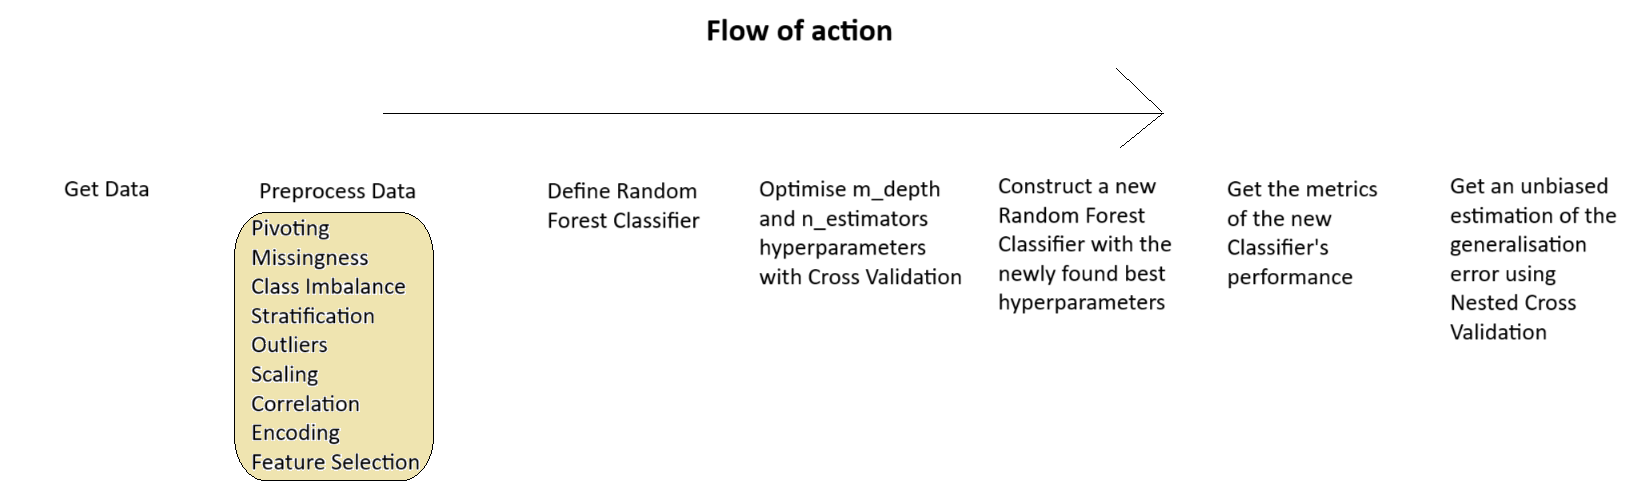

### 4.2 Setting and optimising hyperparameters

In [45]:
# Updating the X and y DataFrames such that they consist of all the records but with the 15 most important features only
X = pd.concat([X_train, X_test], ignore_index=True)
y = pd.concat([y_train, y_test], ignore_index=True)
print(y.shape)
y = np.ravel(y)
print(y.shape)

(30840, 1)
(30840,)


In [46]:
# Splitting the data in such a way that there is 70% training data and 30% testing data and the class imbalanced is preserved
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [47]:
# The following code is inspired by (Brownlee, 2020) and 'Exercise3_plot_nested_cross_validation_iris.ipynb' from the course materials

# configure the cross-validation procedure
inner_cv = KFold(n_splits=3, shuffle=True, random_state=1)
outer_cv = KFold(n_splits=3, shuffle=True, random_state=1)
# define the model
random_forest_clf = RandomForestClassifier(random_state=1)
# define search space
p_grid = {'max_depth': [20, 30, 50], 'n_estimators':[20, 50, 100, 200]}
# define search
rfc_hyperparameters_search = GridSearchCV(estimator = random_forest_clf, param_grid = p_grid, cv=inner_cv)
rfc_hyperparameters_search.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=1, shuffle=True),
             estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': [20, 30, 50],
                         'n_estimators': [20, 50, 100, 200]})

In [48]:
print(rfc_hyperparameters_search.best_params_)

{'max_depth': 30, 'n_estimators': 200}


In [49]:
random_forest_clf = RandomForestClassifier(max_depth = rfc_hyperparameters_search.best_params_['max_depth'],
                                           n_estimators = rfc_hyperparameters_search.best_params_['n_estimators'],
                                           random_state=1).fit(X_train, y_train)

### 4.3 Performance metrics for training set

In [50]:
def get_classifier_metrics_on_training_set(clf, X_train, y_train, target_labels):
    
    # Prediction on the train set
    y_train_pred = clf.predict(X_train)
    
    # Confusion Matrix
    conf_matrix = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=target_labels, cmap=plt.cm.Blues)

    # Information on the balanced error
    print("Balanced error rate for training set: {}%".format(((1 - balanced_accuracy_score(y_train, y_train_pred))*100).round(2)))

    # Classification report for the test data and prediction data
    print(classification_report(y_train, y_train_pred))

Balanced error rate for training set: 0.0%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10794
           1       1.00      1.00      1.00     10794

    accuracy                           1.00     21588
   macro avg       1.00      1.00      1.00     21588
weighted avg       1.00      1.00      1.00     21588



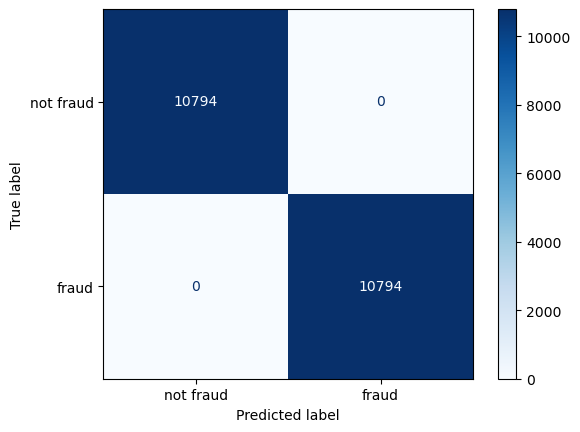

In [51]:
target_labels = ['not fraud', 'fraud']

get_classifier_metrics_on_training_set(random_forest_clf, X_train, y_train, target_labels)

## 5. Technique 2

### 5.1 Motivation for choosing the technique and schematic figure of the analysis process

The second classification technique implemented in the current project is the KNN Classifier. This technique is a lazy learning algorithm which is one of the main differences compared to the Random Forest Classifier. Being a lazy learning algorithm, this means that the KNN Classifier does not learn the training set but just stores it and uses it later to see the closest matches to the newly requested records. This characteristic of the KNN technique makes it very interesting for further investigations because the algorithm actually performes very well and it is interesting to compare its performance to the performance of the Random Forest Classifier. Furthermore, the KNN Classifier is easy to be implemented and understood.

Below is the schematic figure of the analysis process for the KNN Classifier

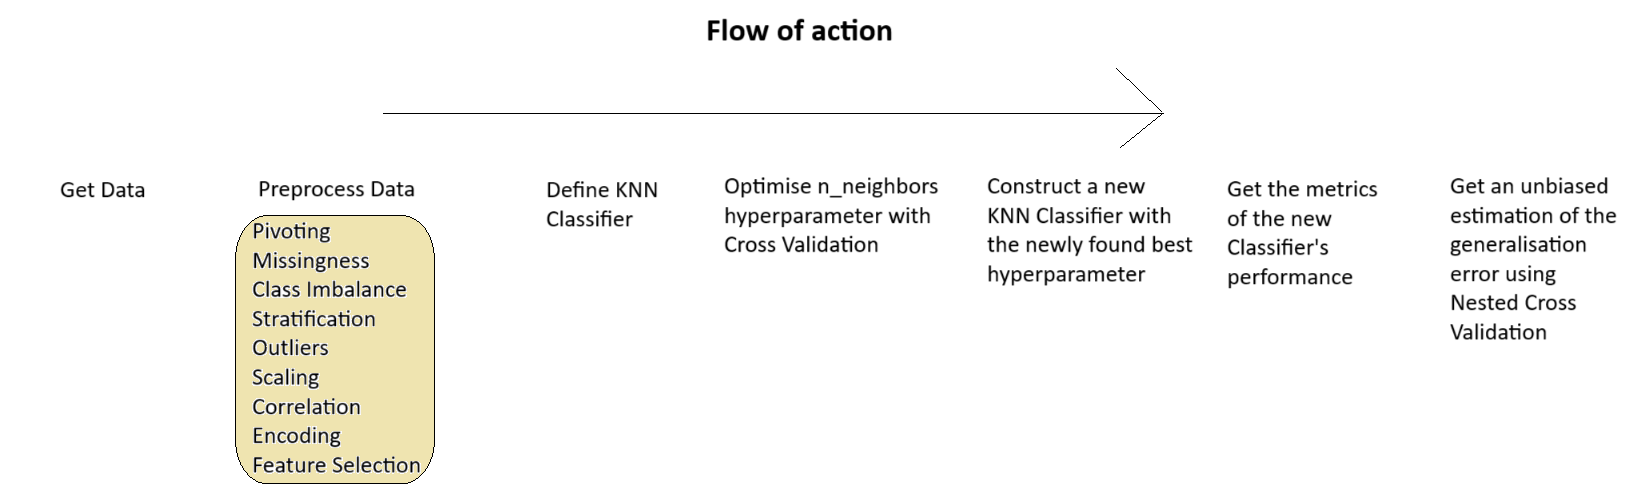

### 5.2 Setting and optimising hyperparameters

In [52]:
# configure the cross-validation procedure
inner_cv = KFold(n_splits=3, shuffle=True, random_state=1)
outer_cv = KFold(n_splits=3, shuffle=True, random_state=1)
# define the model
knn_clf = KNeighborsClassifier()
# define search space
p_grid = {'n_neighbors': [i for i in range(1, 11)]}
# define search
knn_hyperparameters_search = GridSearchCV(estimator = knn_clf, param_grid = p_grid, cv=inner_cv)
knn_hyperparameters_search.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=1, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})

### 5.3 Performance metrics for training set

Balanced error rate for training set: 0.0%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10794
           1       1.00      1.00      1.00     10794

    accuracy                           1.00     21588
   macro avg       1.00      1.00      1.00     21588
weighted avg       1.00      1.00      1.00     21588



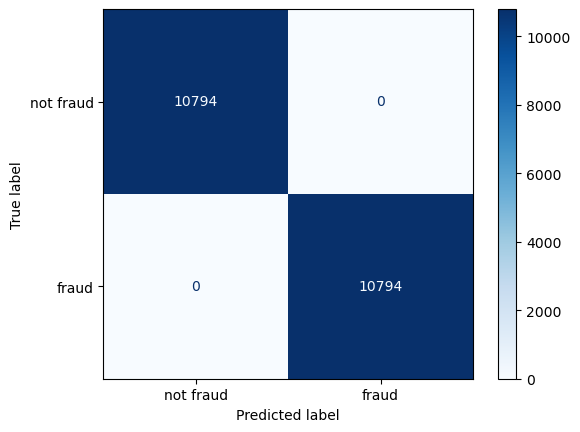

In [53]:
# define the model
knn_clf = KNeighborsClassifier(n_neighbors = knn_hyperparameters_search.best_params_['n_neighbors']).fit(X_train, y_train)

target_labels = ['not fraud', 'fraud']

get_classifier_metrics_on_training_set(knn_clf, X_train, y_train, target_labels)

After testing the two classifiers on the training dataset, both performed 100% perfectly. For the KNN algorithm, this behaviour is expected because with K=1 and training and testing on the same dataset, this means that the algorithm already have exact matches of the requested data. For the Random Forest Classifier, however, these results might mean overfitting. More insightful results will be obtained from testing the algorithms' performances on the testing dataset.

## 6. Comparison of metrics performance for testing

### 6.1 Nested Cross Validation for an unbiased estimation of the generalisation error

In [54]:
rfc_nested_score = cross_val_score(rfc_hyperparameters_search, X, y, cv=outer_cv)
knn_nested_score = cross_val_score(knn_hyperparameters_search, X, y, cv=outer_cv)

print('Random Forest classifier Mean Accuracy: %.3f (with %.3f std)' % (np.mean(rfc_nested_score), np.std(rfc_nested_score)))
print('KNN classifier Mean Accuracy: %.3f (with %.3f std)' % (np.mean(knn_nested_score), np.std(knn_nested_score)))

Random Forest classifier Mean Accuracy: 0.954 (with 0.002 std)
KNN classifier Mean Accuracy: 0.918 (with 0.002 std)


Based on the above results, the Random Forest classifier showed better average performance on a 3-fold nested cross validation.

### 6.2 Performance metrics for testing set

In [55]:
def get_classifier_metrics_on_testing_set(clf, X_test, y_test, target_labels):
    
    # Prediction on the train set
    y_test_pred = clf.predict(X_test)
    
    # Confusion Matrix
    conf_matrix = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=target_labels, cmap=plt.cm.Blues)

    # Information on the balanced error
    print("Balanced error rate for testing set: {}%".format(((1 - balanced_accuracy_score(y_test, y_test_pred))*100).round(2)))

    # Classification report for the test data and prediction data
    print(classification_report(y_test, y_test_pred))

    return conf_matrix.confusion_matrix[0,1], conf_matrix.confusion_matrix[1,0], y_test_pred # return the FP, FN and the predicted targets on testing set

Balanced error rate for testing set: 4.36%
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      4626
           1       0.96      0.95      0.96      4626

    accuracy                           0.96      9252
   macro avg       0.96      0.96      0.96      9252
weighted avg       0.96      0.96      0.96      9252



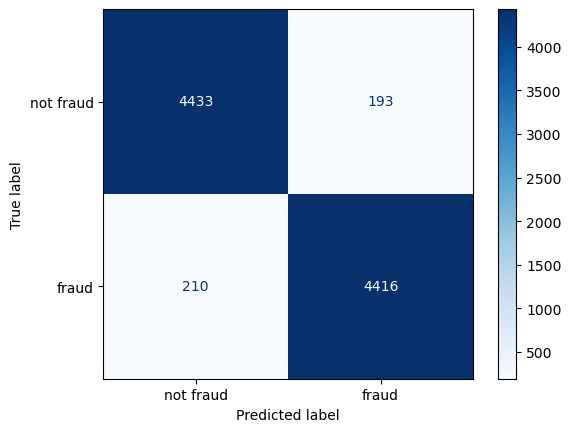

In [56]:
rfc_fp, rfc_fn, y_pred_rfc = get_classifier_metrics_on_testing_set(random_forest_clf, X_test, y_test, target_labels)

Balanced error rate for testing set: 7.73%
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      4626
           1       0.90      0.95      0.92      4626

    accuracy                           0.92      9252
   macro avg       0.92      0.92      0.92      9252
weighted avg       0.92      0.92      0.92      9252



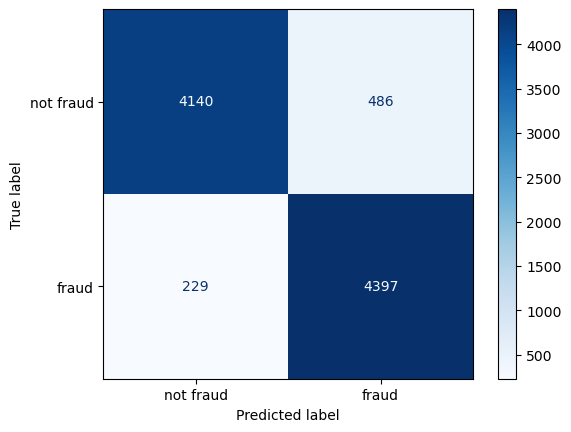

In [57]:
knn_fp, knn_fn, y_pred_knn = get_classifier_metrics_on_testing_set(knn_clf, X_test, y_test, target_labels)

In the context of the project, recall is a more important performance metric because the aim is to minimise the cases where the algorithm predicts a claim being genuine while it actually is fraudulent. This is like this because missing fraudulent claims would cost more to the insurance company rather than misclassifying claims as being fraudulent. Based on the results above, the Random Forest Classifier showed better overall recall results and would be prioritised over the KNN Classifier in this situation.

Additionally, the Random Forest Classifier's balanced error rate is less than 5%, which is what was desired. Compared to this, the KNN's balance error rate is more than 7%. Hence, the Random Forest technique showed better performance in this case, as well.

Overall, the Random Forest Classifier performed clearly better than the KNN Classifier and if a technique should be chosen based on the performance only, this would be the Random Forest. Later it is shown whether this superiority remains when the techniques are compared on the proposed pricing model.

### 6.3 Receiver Operating Characteristic visualisation curve (ROC curve) for model selection

AUC score for the Random Forest Classifier: 0.9564418504107222.
AUC score for the KNN Classifier: 0.922719412019023.


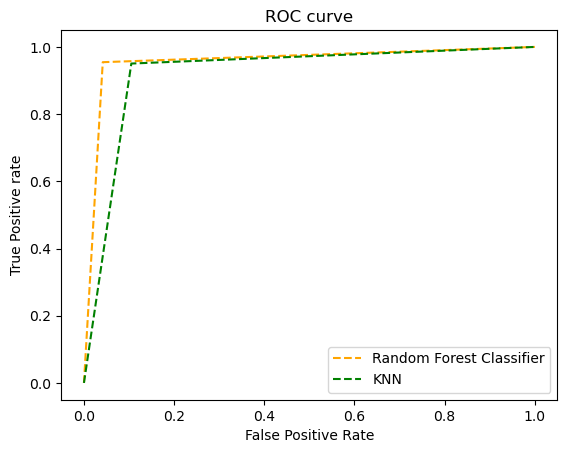

In [58]:
# this code snippet is inspired by (Bhandari, 2020a)

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, y_pred_rfc, pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, y_pred_knn, pos_label=1)

# auc scores
auc_score1 = roc_auc_score(y_test, y_pred_rfc)
auc_score2 = roc_auc_score(y_test, y_pred_knn)

print("AUC score for the Random Forest Classifier: {}.\nAUC score for the KNN Classifier: {}.".format(auc_score1, auc_score2))

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Random Forest Classifier')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='KNN')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
#plt.show()

Based on the results above, the Random Forest Classifier has better AUC result, too, meaning it is a better algorithm than the KNN Classifier in the given context.

### 6.4 Check for overfitting

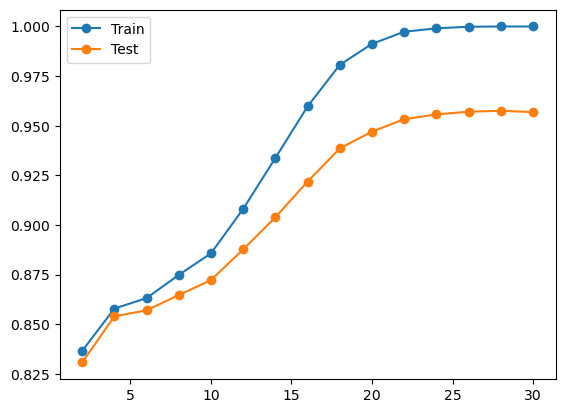

In [59]:
# define lists to collect scores
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(2, 31, 2)]
# evaluate a decision tree for each depth
for i in values:
	# configure the model
	rfc_model = RandomForestClassifier(max_depth=i, n_estimators = rfc_hyperparameters_search.best_params_['n_estimators'])
	# fit model on the training dataset
	rfc_model.fit(X_train, y_train)
	# evaluate on the train dataset
	y_train_predict = rfc_model.predict(X_train)
	train_acc = accuracy_score(y_train, y_train_predict)
	train_scores.append(train_acc)
	# evaluate on the test dataset
	y_test_predict = rfc_model.predict(X_test)
	test_acc = accuracy_score(y_test, y_test_predict)
	test_scores.append(test_acc)
    
# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()

From the results above, the accuracy of the Random Forest Classifier on the testing set increases to a max_depth of around 22/24 when its progress stops increasing. At the same time, the accuracy on the training set keeps increasing until it finally reaches a value of 1, which altogether is exactly what is expected when there is overfitting. Hence, max_depth of 22 or 24 would be the ideal for the given Random Forest Classifier.

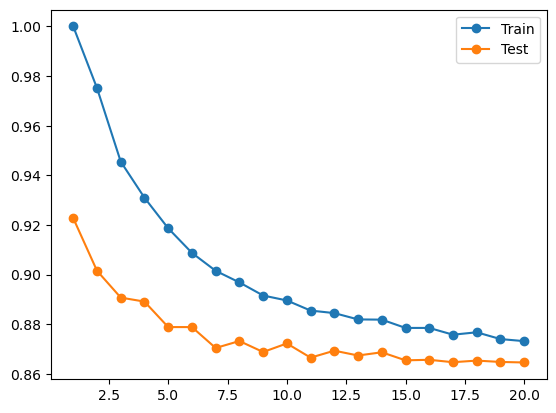

In [60]:
# define lists to collect scores
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 21)]
# evaluate a decision tree for each depth
for i in values:
	# configure the model
	knn_model = KNeighborsClassifier(n_neighbors=i)
	# fit model on the training dataset
	knn_model.fit(X_train, y_train)
	# evaluate on the train dataset
	y_train_predict = knn_model.predict(X_train)
	train_acc = accuracy_score(y_train, y_train_predict)
	train_scores.append(train_acc)
	# evaluate on the test dataset
	y_test_predict = knn_model.predict(X_test)
	test_acc = accuracy_score(y_test, y_test_predict)
	test_scores.append(test_acc)
    
# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()

From the results above, the accuracy of the KNN Classifier on the testing set decreases after n_neighbors = 1. This is a clear sign of overfitting and a value of 1 would be the best for the n_neigbors hyperparameter for the given KNN classifier. Interestingly, the accuracy of the classifier on the training set also decreases after n_neighbors = 1.

## 7. Final recommendation of the best model

### 7.1 Technical perspective- overfitting discussion, complexity and efficiency

In the current project, the Random Forest Classification and the KNN classification were implemented and tested. Both algorithms showed overfitting after some point, as discussed in section 6.4. It is important to note this overfitting because after it happens, the computational complexity becomes bigger while the performance does not improve much if at all.

In terms of complexity, both algorithms use hyperparameters which need to be optimised. The Random Forest Classifier has more hyperparameters and hence it can be said that it is a more complex algorithm in this matter. On the other hand, even though the KNN algorithm just stores the training data and does not learn from it, it has a much bigger computational complexity when it has to deal with the new data from the testing set because it has to compare the entry with all the entries in the training set.

Finally, both techniques are efficient. However, the Random Forest Classifier showed better results overall. Of course, it should be said that the performances of the algorithms depend on the given context. Hence, there are clear results for the given context but this does not mean that the Random Forest Classifier will always show better results than the KNN Classifier.

### 7.2 Business perspective- results interpretation, relevance and balance with a technical perspective

The interpretation of the pricing model is that when a fraudulent claim is made and the classification algorithm marks it as genuine, the insurance company loses the average amount of 'AmountOfTotalClaim' as this represents the total amount paid to the customer by the company. On the other hand, if a claim is marked as fraudulent while it actually is genuine, the company will lose the customer and the average of 'PolicyAnnualPremium' as this is the annual tax being paid to the company by the customer.

In [61]:
print(f"Number of missing values in 'AmountOfTotalClaim' attribute: {df_claim[df_claim['AmountOfTotalClaim']=='MISSEDDATA'].shape[0]}")

Number of missing values in 'AmountOfTotalClaim' attribute: 50


There are only 50 records in df_claim with a missing value, so they are just dropped

In [62]:
try:
    df_claim.drop(df_claim[df_claim['AmountOfTotalClaim'] == 'MISSEDDATA'].index, inplace = True)
except KeyError as e:
    print(e)

In [63]:
df_claim['AmountOfTotalClaim'] = df_claim['AmountOfTotalClaim'].astype(float)

# the loss when a claim is marked as genuine while it actually was a fraud
fraud_loss = df_claim['AmountOfTotalClaim'].mean().round(2) # average sum being paid to a customer by the insurance company when a claim is made and accepted as genuine

In [64]:
# cost for losing a client as a result of missclassified genuine claim - the company loses customer's policy annual premium
client_loss = df_policy['PolicyAnnualPremium'].mean().round(2) # average annual amount of money paid by a customer to have a policy (this is income for the insurance company)

In [65]:
rfc_loss = rfc_fp * client_loss + rfc_fn * fraud_loss
knn_loss = knn_fp * client_loss + knn_fn * fraud_loss

print("Total loss for the insurance company if the Random Forest Clissifier is used: {}".format(rfc_loss.round(2)))
print("Total loss for the insurance company if the KNN Clissifier is used: {}".format(knn_loss.round(2)))

Total loss for the insurance company if the Random Forest Clissifier is used: 11227112.79
Total loss for the insurance company if the KNN Clissifier is used: 12588845.53


From the tests above, it would be better for the insurance company to use the Random Forest Classifier because it would lead to less loss.

A more accurate pricing model would be if the actual 'AmountOfTotalClaim' and 'PolicyAnnualPremium' are considered for the given customer, taking into account their 'CustomerID', for example. Additionally, in order the pricing model to be as accurate as possible, it might be taken into account that when the insurance company loses a customer they do not lose just one annual policy premium but possibly many more which would have been paid by the customer had they remained with the company. Furthermore, losing one customer might bring a bad reputation for the company which may lead to further losses. Hence, the pricing model could be much more complicated and complete.

## 8. Conclusion

### What has been successfully accomplished and what has not

On the one hand, the aims of the project were successfully achieved. Two classification techniques were used and compared to each other so that the better one of them is proposed to the insurance company. During the project work, all the data preprocessing techniques were completed successfully. When the classifiers were built, they were successfully optimised and later compared to each other. After thorough performance comparisons as well as comparison on a proposed pricing model, the Random Forest Classifier was successfully proposed as the better algorithm.

On the other hand, both techniques would have benefited from using more hyperparameters with more different possible values. Furthermore, a better pricing model would have been more beneficial for the analyses between the classifiers' performances and consequently for the insurance company, as well.

### Reflect back on the analysis and see what you could have done differently if you were to do the project again

The project would have benefited a lot if it was completed using a more powerful machine. For example, no data attributes would have been dropped because they would have created too many new attributes when being encoded. Furthermore, all hyperparameters and more values for them would have been used when selecting the best of them during the cross validation processes. Additionally, more classification techniques could have been implemented. All of these analyses and techniques would benefit the project a lot and are something I would do if I am to do the project again using a more powerful machine and having more time.

### Wish list of future work that you would do to take the project forward

As discussed above, using a more powerful machine is one of the main things I would do to move the project forward. This would enable me to do more thorough analyses and present better results, eventually. Additionally, I believe the project would also benefit if more balanced raw data is used. In the current project, data duplications had to be made in order to balance the classes in the data, which is not desirable as it might lead to biasing the classification algorithms. So, a next step in moving the project forward would be to collect better data from the insurance company and/or use similar data from other insurance companies.

### References

Bhandari, A. (2020a). Guide to AUC ROC Curve in Machine Learning. [online] Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/#Understanding_the_AUC-ROC_Curve_in_Python [Accessed 2 Jan. 2025].

Bhandari, A. (2020b). What is Multicollinearity? Here’s Everything You Need to Know. [online] Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/.

Brownlee, J. (2020). Nested Cross-Validation for Machine Learning with Python. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/.

Rafael Alencar (2017) Resampling strategies for imbalanced datasets. https://www.kaggle.com/code/rafjaa/resampling-strategies-for-imbalanced-datasets.